In [1]:
pip install transformers datasets torch scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the dataset
data = pd.read_csv('./drive/MyDrive/ColabNotebooks/semeval_project/train_data.csv')

# Split dataset
train_texts, val_texts, train_labels, val_labels = train_test_split(
    data['clean_text'],
    data[['anger', 'fear', 'joy', 'sadness', 'surprise']].values,
    test_size=0.2,
    random_state=42
)


In [5]:
from transformers import AutoTokenizer

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained('j-hartmann/emotion-english-distilroberta-base')

# Tokenize text
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(list(val_texts), truncation=True, padding=True, max_length=128)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/294 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

In [6]:
import torch

class EmotionDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.float)
        return item

# Create dataset objects
train_dataset = EmotionDataset(train_encodings, train_labels)
val_dataset = EmotionDataset(val_encodings, val_labels)


In [8]:
from transformers import AutoModelForSequenceClassification

# Load model with 5 output labels for multi-label classification
model = AutoModelForSequenceClassification.from_pretrained(
    'j-hartmann/emotion-english-distilroberta-base',
    num_labels=5,
    problem_type="multi_label_classification",
    ignore_mismatched_sizes=True
)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at j-hartmann/emotion-english-distilroberta-base and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([7, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([7]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
from torch.utils.data import DataLoader
from transformers import AdamW
from transformers import get_scheduler

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

# Define optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=5e-5)
num_training_steps = len(train_loader) * 3  # 3 epochs
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [12]:
from torch.nn import BCEWithLogitsLoss
from transformers import Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, f1_score

# Use GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Training loop
def train_epoch(model, train_loader):
    model.train()
    loss_fn = BCEWithLogitsLoss()
    for batch in train_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = loss_fn(outputs.logits, batch['labels'])
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

def evaluate(model, val_loader):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in val_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss_fn = BCEWithLogitsLoss()
            total_loss += loss_fn(outputs.logits, batch['labels']).item()

            # Collect predictions and true labels
            logits = torch.sigmoid(outputs.logits).cpu().numpy()
            preds = (logits > 0.5).astype(int)  # Threshold for multi-label classification
            all_preds.extend(preds)
            all_labels.extend(batch['labels'].cpu().numpy())

      # Calculate metrics
        all_preds = torch.tensor(all_preds).cpu() # Move all_preds to cpu before converting to NumPy
        all_labels = torch.tensor(all_labels).cpu() # Move all_labels to cpu before converting to NumPy
        accuracy = accuracy_score(all_labels.numpy(), all_preds.numpy()) # convert to NumPy arrays before passing to accuracy_score
        f1 = f1_score(all_labels.numpy(), all_preds.numpy(), average='weighted') # convert to NumPy arrays before passing to f1_score

    return total_loss / len(val_loader), accuracy, f1

# File to store metrics
metrics_file = "metrics_log.txt"
with open(metrics_file, 'w') as f:
    f.write("Epoch\tValidation_Loss\tAccuracy\tF1_Score\n")

# Training loop with metrics logging
epochs = 2
for epoch in range(epochs):
    train_epoch(model, train_loader)
    val_loss, accuracy, f1 = evaluate(model, val_loader)

    # Log metrics
    print(f'Epoch {epoch + 1}, Validation Loss: {val_loss}, Accuracy: {accuracy}, F1 Score: {f1}')
    with open(metrics_file, 'a') as f:
        f.write(f"{epoch + 1}\t{val_loss:.4f}\t{accuracy:.4f}\t{f1:.4f}\n")


Epoch 1, Validation Loss: 0.3953494940485273, Accuracy: 0.417607223476298, F1 Score: 0.7019994992316219
Epoch 2, Validation Loss: 0.3953494940485273, Accuracy: 0.417607223476298, F1 Score: 0.7019994992316219


In [13]:
# Save the new model
model.save_pretrained('emotion_model_pretrained')
tokenizer.save_pretrained('emotion_model_pretrained')


('emotion_model_pretrained/tokenizer_config.json',
 'emotion_model_pretrained/special_tokens_map.json',
 'emotion_model_pretrained/vocab.json',
 'emotion_model_pretrained/merges.txt',
 'emotion_model_pretrained/added_tokens.json',
 'emotion_model_pretrained/tokenizer.json')

In [17]:
#Testing the results
from transformers import pipeline

# Load the model and tokenizer
emotion_model = pipeline('text-classification', model='emotion_model_pretrained', tokenizer='emotion_model_pretrained', return_all_scores=True)

# Predict
text = "I feel so happy today!"
predictions = emotion_model(text)
print(predictions)


Device set to use cpu


[[{'label': 'LABEL_0', 'score': 0.061129894107580185}, {'label': 'LABEL_1', 'score': 0.04180305823683739}, {'label': 'LABEL_2', 'score': 0.9680857062339783}, {'label': 'LABEL_3', 'score': 0.07458458840847015}, {'label': 'LABEL_4', 'score': 0.1456994116306305}]]


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [19]:
# Load the model for inference
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained("emotion_model_pretrained")

In [21]:
# Inference
def predict_emotions(text, model, tokenizer, device):
    model.eval()
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)
    with torch.no_grad():
        outputs = model(inputs['input_ids'], inputs['attention_mask'])
        probs = torch.sigmoid(outputs.logits).cpu().numpy() # Apply sigmoid to outputs.logits
    return probs > 0.5

text = "I can not see anything."
predicted_emotions = predict_emotions(text, model, tokenizer, device)
print("Predicted Emotions:", predicted_emotions)

Predicted Emotions: [[False  True False False  True]]


In [26]:
# To see the output in emotion name format
def predict_emotions_with_details(text, model, tokenizer, emotion_labels, device):
    """
    Predict emotions for a given text with details.
    Returns the predicted emotions, binary outputs, and probabilities.
    """
    model.eval()
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)

    # Remove token_type_ids if not required by the model
    if "token_type_ids" in inputs:
        del inputs["token_type_ids"]

    with torch.no_grad():
        outputs = model(**inputs)  # Use model inputs
        logits = outputs.logits if hasattr(outputs, "logits") else outputs  # Handle plain tensor outputs
        probs = torch.sigmoid(logits).cpu().numpy()[0]  # Convert logits to probabilities

    # Determine binary outputs (True/False) based on a threshold
    binary_outputs = probs > 0.5

    # Map True/False to emotion labels
    predicted_emotion = [emotion for emotion, binary in zip(emotion_labels, binary_outputs) if binary]

    return predicted_emotion, binary_outputs, probs


In [29]:
# One by one model testing
text = "Yes, new model is ready."
emotion_labels = ["anger", "fear", "joy", "sadness", "surprise"]

predicted_emotion, binary_outputs, probabilities = predict_emotions_with_details(
    text, model, tokenizer, emotion_labels, device
)

print("Predicted Emotion(s):", predicted_emotion)
print("Binary Outputs (True/False):", binary_outputs)
print("Probabilities:", probabilities)

Predicted Emotion(s): ['joy', 'surprise']
Binary Outputs (True/False): [False False  True False  True]
Probabilities: [0.03535273 0.07021486 0.8129399  0.02740201 0.53675115]


Fine Tuning with RoBERta

In [30]:
# load the required packages
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW, get_scheduler
from sklearn.metrics import accuracy_score, f1_score
from torch.nn import BCEWithLogitsLoss
from torch.utils.data import DataLoader
import torch

In [31]:
# Load the previously fine-tuned model and tokenizer
model_path = 'emotion_model_pretrained'  # Path where the initial fine-tuned model is saved
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

# Prepare dataset (assuming it's already tokenized and split as before)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

In [32]:
# Optimizer with modified learning rate for fine-tuning
optimizer = AdamW(model.parameters(), lr=2e-5)  # Adjust the learning rate for fine-tuning

# Learning rate scheduler
num_training_steps = len(train_loader) * 3  # 3 fine-tuning epochs
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [33]:
# Use GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-5): 6 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
           

In [36]:
# Training loop
def train_epoch(model, train_loader):
    model.train()
    loss_fn = BCEWithLogitsLoss()
    for batch in train_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = loss_fn(outputs.logits, batch['labels'])
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

def evaluate(model, val_loader):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in val_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss_fn = BCEWithLogitsLoss()
            total_loss += loss_fn(outputs.logits, batch['labels']).item()

            logits = torch.sigmoid(outputs.logits).cpu().numpy()
            preds = (logits > 0.5).astype(int)
            all_preds.extend(preds)
            all_labels.extend(batch['labels'].cpu().numpy())

        all_preds = torch.tensor(all_preds).cpu()
        all_labels = torch.tensor(all_labels).cpu()

        # Convert tensors to NumPy arrays before using with scikit-learn
        accuracy = accuracy_score(all_labels.numpy(), all_preds.numpy())
        f1 = f1_score(all_labels.numpy(), all_preds.numpy(), average='weighted')

    return total_loss / len(val_loader), accuracy, f1

# Fine-tuning loop
metrics_file = "metrics_fine_tuned.txt"
with open(metrics_file, 'w') as f:
    f.write("Epoch\tValidation_Loss\tAccuracy\tF1_Score\n")

epochs = 2  # Fine-tuning for additional 3 epochs
for epoch in range(epochs):
    train_epoch(model, train_loader)
    val_loss, accuracy, f1 = evaluate(model, val_loader)
    print(f'Epoch {epoch + 1}, Validation Loss: {val_loss}, Accuracy: {accuracy}, F1 Score: {f1}')
    with open(metrics_file, 'a') as f:
        f.write(f"{epoch + 1}\t{val_loss:.4f}\t{accuracy:.4f}\t{f1:.4f}\n")

Epoch 1, Validation Loss: 0.41864210420421194, Accuracy: 0.4288939051918736, F1 Score: 0.7059309149491207
Epoch 2, Validation Loss: 0.4190876606319632, Accuracy: 0.417607223476298, F1 Score: 0.7017234506601908


In [37]:
# Save the fine-tuned model
model.save_pretrained('emotion_model_fine_tuned')
tokenizer.save_pretrained('emotion_model_fine_tuned')

('emotion_model_fine_tuned/tokenizer_config.json',
 'emotion_model_fine_tuned/special_tokens_map.json',
 'emotion_model_fine_tuned/vocab.json',
 'emotion_model_fine_tuned/merges.txt',
 'emotion_model_fine_tuned/added_tokens.json',
 'emotion_model_fine_tuned/tokenizer.json')

Model testing and comparision with Manually tested dataset

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Load the fine-tuned model and tokenizer
model_path = 'emotion_model_fine_tuned'
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Prepare test data
test_texts = data['text']  # Assuming 'data' contains your full dataset
manual_labels = data[['anger', 'fear', 'joy', 'sadness', 'surprise']].values  # Manually labeled emotions

# Tokenize test texts
test_encodings = tokenizer(list(test_texts), truncation=True, padding=True, max_length=128, return_tensors="pt")
test_encodings = {key: val.to(device) for key, val in test_encodings.items()}

# Get predictions
model.eval()
with torch.no_grad():
    outputs = model(**test_encodings)
    logits = torch.sigmoid(outputs.logits)  # Convert logits to probabilities
    predictions = (logits.cpu().numpy() > 0.5).astype(int)  # Binary predictions (threshold = 0.5)

# Generate classification report
print("Classification Report:\n")
print(classification_report(manual_labels, predictions, target_names=['anger', 'fear', 'joy', 'sadness', 'surprise'], zero_division=0))

# Calculate confusion matrix for each label
for i, emotion in enumerate(['anger', 'fear', 'joy', 'sadness', 'surprise']):
    cm = confusion_matrix(manual_labels[:, i], predictions[:, i])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f"Not {emotion}", emotion])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix for {emotion}")
    plt.show()

# Graph: Compare manual vs model predictions
manual_totals = np.sum(manual_labels, axis=0)
predicted_totals = np.sum(predictions, axis=0)

x = np.arange(len(['anger', 'fear', 'joy', 'sadness', 'surprise']))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x - width / 2, manual_totals, width, label='Manual Labels')
plt.bar(x + width / 2, predicted_totals, width, label='Model Predictions')

plt.xticks(x, ['anger', 'fear', 'joy', 'sadness', 'surprise'])
plt.xlabel('Emotions')
plt.ylabel('Number of Samples')
plt.title('Comparison of Manual Labels and Model Predictions')
plt.legend()
plt.show()


# Adjustements with the pos_weight

In [39]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score, f1_score
from torch.utils.data import DataLoader
from torch.nn import BCEWithLogitsLoss
import numpy as np

# Step 1: Calculate pos_weight for each class
emotions = ['anger', 'fear', 'joy', 'sadness', 'surprise']
pos_weights = []

for emotion in emotions:
    pos_count = data[emotion].sum()  # Number of positive examples
    neg_count = len(data) - pos_count  # Number of negative examples
    pos_weights.append(neg_count / pos_count)

pos_weights_tensor = torch.tensor(pos_weights, dtype=torch.float32).to(device)

In [40]:
# Step 2: Define the updated loss function
criterion = BCEWithLogitsLoss(pos_weight=pos_weights_tensor)

In [41]:
# Step 3: Training Loop with Adjusted Loss Function
def train_epoch(model, train_loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for batch in train_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = criterion(outputs.logits, batch['labels'])
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_loss += loss.item()
    return total_loss / len(train_loader)

In [44]:
# Step 4: Validation Loop
def evaluate(model, val_loader, criterion):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in val_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = criterion(outputs.logits, batch['labels'])
            total_loss += loss.item()

            logits = torch.sigmoid(outputs.logits).cpu().numpy()
            preds = (logits > 0.5).astype(int)
            all_preds.extend(preds)
            all_labels.extend(batch['labels'].cpu().numpy())

    # Convert the lists to NumPy arrays before calculating metrics
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')

    return total_loss / len(val_loader), accuracy, f1

In [45]:
# Step 5: Training with Adjusted Loss
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
epochs = 2
for epoch in range(epochs):
    train_loss = train_epoch(model, train_loader, optimizer, criterion)
    val_loss, accuracy, f1 = evaluate(model, val_loader, criterion)
    print(f"Epoch {epoch + 1}: Train Loss = {train_loss}, Val Loss = {val_loss}, Accuracy = {accuracy}, F1 Score = {f1}")

# Save the final fine-tuned model
model.save_pretrained('emotion_model_adjusted')
tokenizer.save_pretrained('emotion_model_adjusted')

Epoch 1: Train Loss = 0.2242130338474437, Val Loss = 0.8484962752887181, Accuracy = 0.37020316027088035, F1 Score = 0.7155910302639777
Epoch 2: Train Loss = 0.1714020878210798, Val Loss = 0.9561928468091148, Accuracy = 0.3972911963882618, F1 Score = 0.7136821901190274


('emotion_model_adjusted/tokenizer_config.json',
 'emotion_model_adjusted/special_tokens_map.json',
 'emotion_model_adjusted/vocab.json',
 'emotion_model_adjusted/merges.txt',
 'emotion_model_adjusted/added_tokens.json',
 'emotion_model_adjusted/tokenizer.json')

Visualization

In [50]:
import torch
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt

# Step 1: Initialize lists to store metrics for each emotion and each epoch
precision_per_epoch = {emotion: [] for emotion in emotions}
recall_per_epoch = {emotion: [] for emotion in emotions}
f1_per_epoch = {emotion: [] for emotion in emotions}

In [55]:
# Step 2: Training and Evaluation with Metric Tracking
def evaluate_metrics(model, val_loader, criterion):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in val_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            logits = torch.sigmoid(outputs.logits).cpu().numpy()
            preds = (logits > 0.5).astype(int)
            all_preds.extend(preds)
            all_labels.extend(batch['labels'].cpu().numpy())

    # Calculate metrics (precision, recall, f1) for each emotion
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    for i, emotion in enumerate(emotions):
        precision, recall, f1, _ = precision_recall_fscore_support(
            all_labels[:, i], all_preds[:, i], average='binary', zero_division=0
        )
        precision_per_epoch[emotion].append(precision)
        recall_per_epoch[emotion].append(recall)
        f1_per_epoch[emotion].append(f1)

In [56]:
# Step 3: Train and evaluate model while tracking the metrics
for epoch in range(epochs):
    train_loss = train_epoch(model, train_loader, optimizer, criterion)
    val_loss, accuracy, f1 = evaluate(model, val_loader, criterion)
    evaluate_metrics(model, val_loader, criterion)
    print(f"Epoch {epoch + 1}: Train Loss = {train_loss}, Val Loss = {val_loss}, Accuracy = {accuracy}, F1 Score = {f1}")

Epoch 1: Train Loss = 0.09313737899736241, Val Loss = 1.0146090068987437, Accuracy = 0.39954853273137697, F1 Score = 0.7145477688116202
Epoch 2: Train Loss = 0.07555518972242738, Val Loss = 1.1375177193965231, Accuracy = 0.43340857787810383, F1 Score = 0.7307998293210647


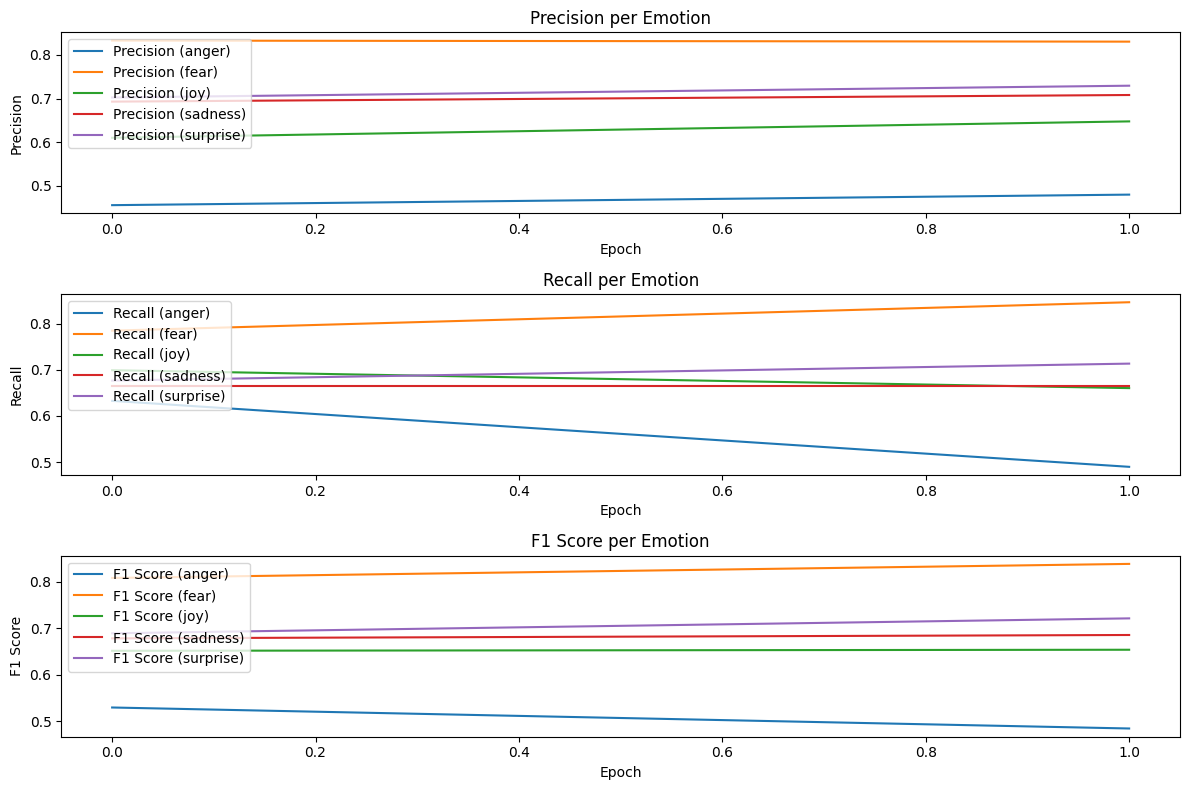

In [57]:
# Step 4: Plotting Precision, Recall, and F1 Score over epochs
plt.figure(figsize=(12, 8))

# Plot Precision for each emotion
plt.subplot(3, 1, 1)
for emotion in emotions:
    plt.plot(precision_per_epoch[emotion], label=f'Precision ({emotion})')
plt.title('Precision per Emotion')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend(loc='upper left')

# Plot Recall for each emotion
plt.subplot(3, 1, 2)
for emotion in emotions:
    plt.plot(recall_per_epoch[emotion], label=f'Recall ({emotion})')
plt.title('Recall per Emotion')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend(loc='upper left')

# Plot F1 Score for each emotion
plt.subplot(3, 1, 3)
for emotion in emotions:
    plt.plot(f1_per_epoch[emotion], label=f'F1 Score ({emotion})')
plt.title('F1 Score per Emotion')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

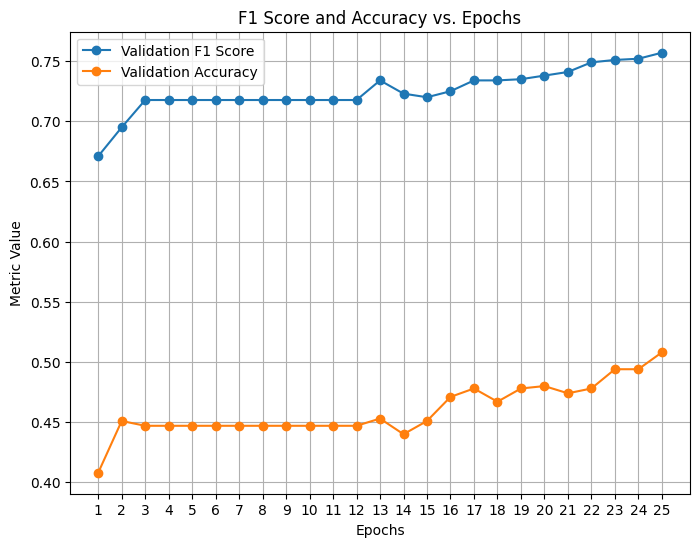

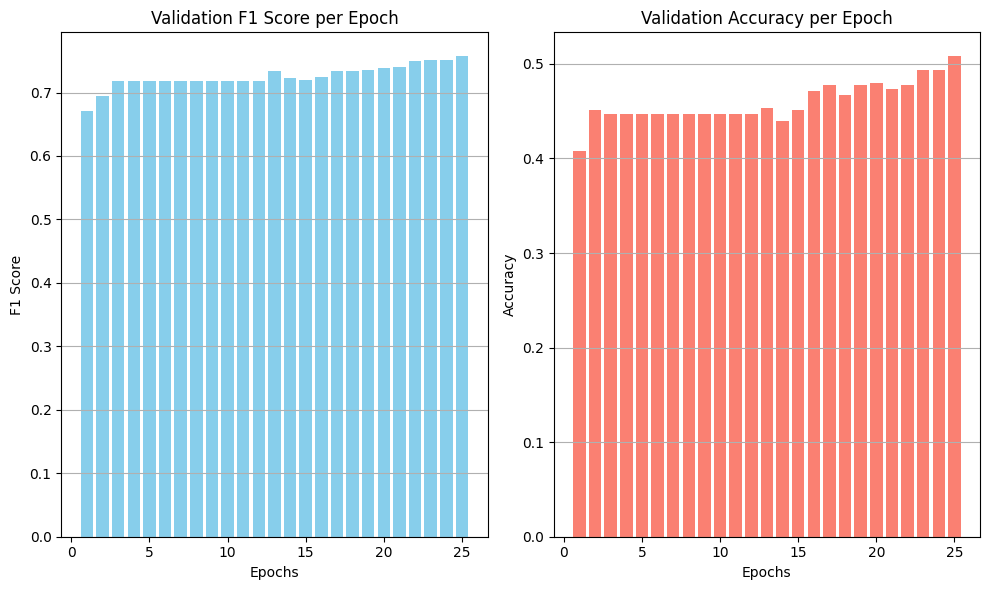

In [12]:
import matplotlib.pyplot as plt

# Manually added F1 score values for each epoch
val_f1_scores = [0.671, 0.695, 0.7177, 0.7177, 0.7177, 0.7177, 0.7177, 0.7177, 0.7177, 0.7177, 0.7177, 0.7177, 0.734, 0.723, 0.720, 0.725, 0.734, 0.734, 0.735, 0.738, 0.741, 0.749, 0.751, 0.752, 0.757] 

# in the graph i also wish to include accuracy of my model
# Manually added accuracy values for each epoch
val_accuracy = [0.408, 0.451, 0.447, 0.447, 0.447, 0.447, 0.447, 0.447, 0.447, 0.447, 0.447, 0.447, 0.453, 0.440, 0.451, 0.471, 0.478, 0.467, 0.478, 0.480, 0.474, 0.478, 0.494, 0.494, 0.508]  
# Plot F1 Score and Accuracy across epochs
plt.figure(figsize=(8, 6))

# Adjust the x-axis range to match the number of F1 scores
plt.plot(range(1, len(val_f1_scores) + 1), val_f1_scores, marker='o', label='Validation F1 Score')
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, marker='o', label='Validation Accuracy')

plt.title("F1 Score and Accuracy vs. Epochs")
plt.xlabel("Epochs")
plt.ylabel("Metric Value")
plt.legend()
plt.grid(True)
plt.xticks(range(1, len(val_f1_scores) + 1))  # Set x-ticks to match epochs
#plt.savefig('f1_accuracy_plot.png')
plt.show()

# give me the bar chart for both f1 score and accuracy individually
# Plot F1 Score and Accuracy as Bar Charts
plt.figure(figsize=(10, 6))

# F1 Score Bar Chart
plt.subplot(1, 2, 1)
plt.bar(range(1, len(val_f1_scores) + 1), val_f1_scores, color='skyblue')
plt.title("Validation F1 Score per Epoch")
plt.xlabel("Epochs")
plt.ylabel("F1 Score")
plt.grid(axis='y')

# Accuracy Bar Chart
plt.subplot(1, 2, 2)
plt.bar(range(1, len(val_accuracy) + 1), val_accuracy, color='salmon')
plt.title("Validation Accuracy per Epoch")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid(axis='y')

plt.tight_layout()
plt.savefig('f1_accuracy_barchart.png')
plt.show()





